In [1]:
import numpy as np
import healpy as hp
import scipy as sp
import matplotlib.pyplot as plt
from astropy import constants
from astropy import units

### Problem 1
First, load in the power spectrum example file. Only going to use the first $n_\ell$ values of $\ell$ as scaling up the amount of $\ell$ you use quickly raises computational time.

In [2]:
nl = int(1000.0)
ps = np.loadtxt('../../phys641/problem_sets/example_ps.txt')
ps_1 = ps[:nl,0]

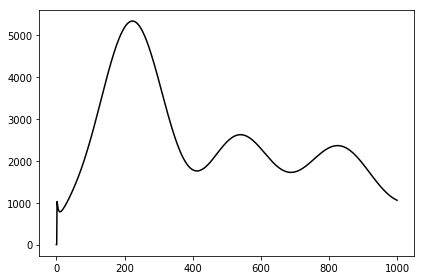

In [3]:
plt.plot(ps_1,c='k')
plt.tight_layout()
plt.show()

Now, turn the $\ell (\ell + 1) C_\ell / 2\pi$ into $C_\ell$ by using the appropriate factors. I just set $C_0$ to $0$ as there is a singularity when solving for $C_\ell$ unless I impose that condition. Also note that $\ell = 1$ corresponds to the dipole part of the CMB anisotropies, and the earth's motion with respect to the CMB rest frame dominates this and cannot easily be separated from the dipole caused by structure in early times. Because $C_0$ and $C_1$ are $0$, the corresponding $a_{\ell m}$ will also end up being zero.

In [4]:
inds = np.arange(1,nl)
c_l = ps_1[1:] * 2 * np.pi/(inds*(inds+1))
c_l = np.insert(c_l,0,0)

What should the variance on the map be? Our function is:

$$T(\theta, \phi) = \sum_l \sum_m Y_l^m(\theta, \phi) a_{l m}$$

And we want to find the expected variance over the entire spherical map, $<T^2>$:

\begin{align}
<T^2> &= \frac{1}{4\pi} \int T^2 d\Omega \\
&= \frac{1}{4\pi} \int \sum_{l m} Y_l^m a_{l m} \sum_{l' m'} Y_{l'}^{m' *} a_{l' m'}^* \\
&= \frac{1}{4\pi} \sum_{l m} \sum_{l' m'} a_{l m} a_{l' m'} \int Y_l^m Y_{l'}^{m' *} \\
&= \frac{1}{4\pi} \sum_{l m} \sum_{l' m'} a_{l m} a_{l' m'} \delta_{l l'} \delta_{m m'} \\
&= \frac{1}{4\pi} \sum_{l} \sum_{m} |a_{l m}|^2 \\
&= \frac{1}{4\pi} \sum_{l} (2\ell + 1)C_\ell
\end{align}

So, let's calculate the expected variance and compare later when we've generated a map.

In [5]:
inds = np.arange(0,nl)
expected_var = np.sum(((2*inds+1)*c_l)/(4*np.pi))
print('Expected variance: %.2f' %(expected_var))

Expected variance: 11565.38


Now generate my $a_{\ell m}$. healpix expects l(l+1)/2 $a_{\ell m}$ values: no negative $m$ for any $a_{\ell m}$

In [6]:
nm_max = int((nl+1)*(nl+2)/2)

alm = []
for m in range(nm_max):
    for l in range(0,nl):
        if m <= l & l == 0:
            alm.append(np.random.normal(0,np.sqrt(c_l[l-1])) + 0.j)
        elif m <= l:
            alm.append((1/2**0.5)*np.random.normal(0,np.sqrt(c_l[l-1])) + 
                       (1/2**0.5)*np.random.normal(0,np.sqrt(c_l[l-1]))*1.j)
        else:
            continue

#Don't know monopole information and C_l[0] is 0
alm[0] = 0
alm[1] = 0
alm = np.array(alm,dtype=complex)

With $a_{\ell m}$ in hand, use healpy to turn this into a CMB map.

In [7]:
#When my nside was less than ~half of the number of l, I lost 
#power in the higher l of my generated PS. This kind of intuitively
#makes sense to me - making the map grid cells larger makes the 
#smallest scale structure I can see larger
cmb_map = hp.alm2map(alm,512)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


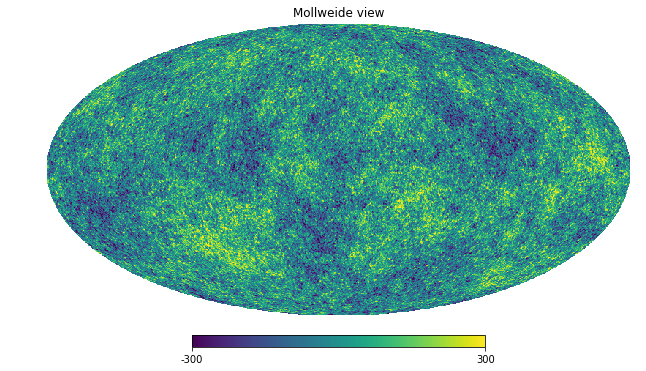

In [8]:
hp.mollview(cmb_map,min=-300,max=300)

Compare the variances

In [9]:
map_var = np.var(cmb_map)
print('Map variance: %.2f'%(map_var))
print('Expected variance: %.2f'%(expected_var))
print('Percentage Difference: %.2f'%(abs((expected_var-map_var)/(map_var + expected_var)/2 * 100)))

Map variance: 12004.55
Expected variance: 11565.38
Percentage Difference: 0.93


Prediction was good! Now turn the generated CMB map into a power spectrum, and compare to the power spectrum that was given

In [10]:
c_l_gen = hp.anafast(cmb_map,lmax=nl-1)

In [11]:
inds = np.arange(0,nl)
ps_gen = inds*(inds+1)*c_l_gen/(2*np.pi)

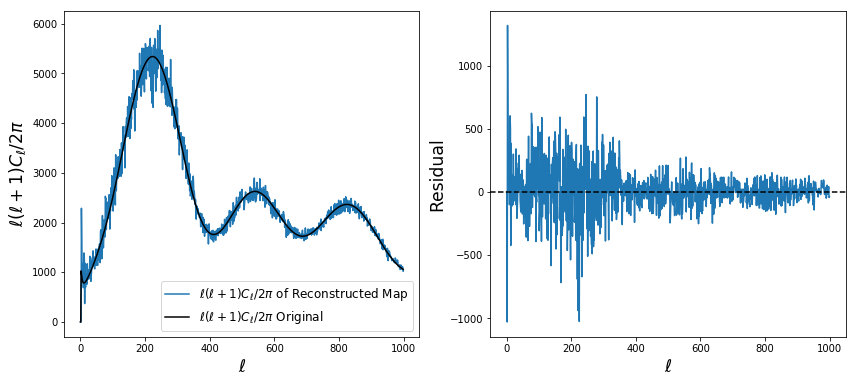

In [12]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,6))
ax1.plot(ps_gen, label='$\ell(\ell+1)$$C_\ell$/2$\pi$ of Reconstructed Map')
ax1.plot(ps_1, label='$\ell(\ell+1)$$C_\ell$/2$\pi$ Original',c='k')
ax1.legend(fontsize='large')
ax1.set_xlabel('$\ell$',fontsize='xx-large')
ax1.set_ylabel('$\ell(\ell+1)$$C_\ell$/2$\pi$',fontsize='xx-large')
ax2.plot(ps_gen - ps_1)
ax2.axhline(c='k',ls='--')
ax2.set_xlabel('$\ell$',fontsize='xx-large')
ax2.set_ylabel('Residual',fontsize='xx-large')
plt.show()

The reconstructed power spectrum is in very good qualitative agreement with the provided power spectrum! Now I'll redo the problem but generating my alm with `synalm` and making a map from my $C_\ell$ with `synfast`

In [13]:
cmb_map_gen = hp.synfast(c_l,512)

/home/marcus/miniconda3/lib/python3.6/site-packages/healpy/sphtfunc.py:390: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


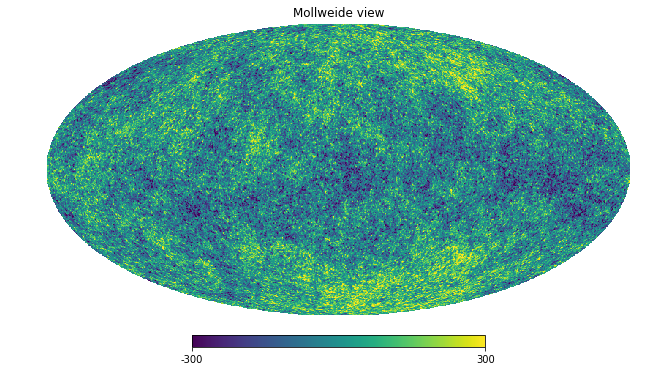

In [14]:
hp.mollview(cmb_map_gen,min=-300,max=300)

In [15]:
c_l_gen2 = hp.anafast(cmb_map_gen,lmax=nl-1)
ps_gen2 = inds*(inds+1)*c_l_gen2/(2*np.pi)

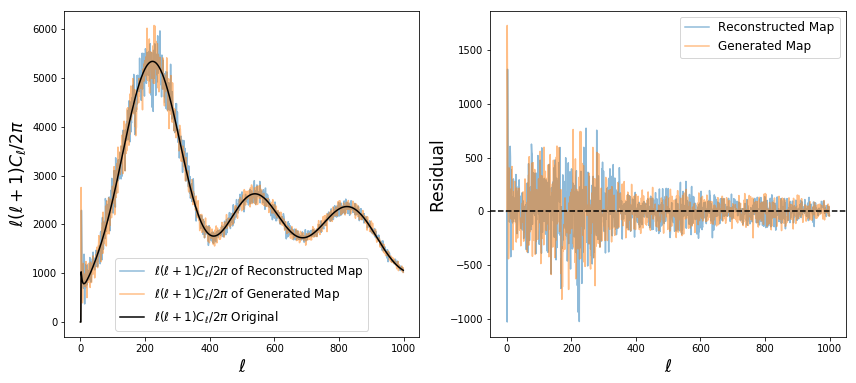

In [16]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,6))
ax1.plot(ps_gen, label='$\ell(\ell+1)$$C_\ell$/2$\pi$ of Reconstructed Map',alpha=0.5)
ax1.plot(ps_gen2, label='$\ell(\ell+1)$$C_\ell$/2$\pi$ of Generated Map',alpha=0.5)
ax1.plot(ps_1, label='$\ell(\ell+1)$$C_\ell$/2$\pi$ Original',c='k')
ax1.legend(fontsize='large')
ax1.set_xlabel('$\ell$',fontsize='xx-large')
ax1.set_ylabel('$\ell(\ell+1)$$C_\ell$/2$\pi$',fontsize='xx-large')
ax2.plot(ps_gen - ps_1,label='Reconstructed Map',alpha=0.5)
ax2.plot(ps_gen2 - ps_1,label='Generated Map',alpha=0.5)
ax2.axhline(c='k',ls='--')
ax2.legend(fontsize='large')
ax2.set_xlabel('$\ell$',fontsize='xx-large')
ax2.set_ylabel('Residual',fontsize='xx-large')
plt.show()

The comparison to the input is again good.

### Problem 2
Repeating Question 1, but on a flat sky! Recall from class: $\sim$flat box $x$ radians across on the sky and $Y_\ell^\ell$ has $\ell$ periods across the celestial equator. So, the box will contain one period if $x = 2\pi/\ell$. If $k$ are the modes within our box, then $k=1$ will have one period within the box also: so, $x = 2\pi k/\ell$. The smallest $\ell$ that one could think about going to is the $\ell$ for which there is a period within the box, else the resolution of the box is not enough to capture meaningful information: so $\ell = 2\pi/x$ is the smallest $\ell$ that should be used.

So, for our 20 degree (~0.349 radian) box, the smallest $\ell$ that should be used is:

In [17]:
patchsize= 20 #in degrees
x = patchsize*(np.pi/180)
l_min = 2*np.pi/x
print('The minimum l is: %s' % (str(l_min)))

The minimum l is: 18.0


As discussed before, up to some $\ell_{\text{max}}$, there are $(\ell_{max} + 1)(\ell_{max} + 2)/2$ values of  $a_{lm}$  for $m > 0$. For modes up to $k_{\text{max}}$, I believe there will just be $k_{\text{max}}^2$ $k$ modes, as there is a double sum over the y and x 2D k values (assuming that $K_{xi}K_{yj}$ and $K_{xj}K_{yi}$ terms are considered seperate modes). Converting the usual power spectrum to a flat sky one is as simple as pulling out the corresponding $C_k$ for each $|k|$ value. Also, the maximum pixel size to capture all the information should just be 360 degrees divided by the maximum $\ell$. This is because there will be $\ell_{\text{max}}$ wavelengths across the 360 degrees of the sphere, and we need one wavelength to fit in the pixel to capture all of the information.

In [18]:
k_max = int(nl*x/(2*np.pi))
npix = 2*k_max #in one dimension, double for nyquist sampling
pixelsize = patchsize/npix #in degrees

k = np.arange(npix)
k[int(len(k)/2):] = k[int(len(k)/2):] - len(k)
k_x = np.tile(k,(len(k),1))
k_y = k_x.T
k = np.sqrt(k_x**2 + k_y**2)

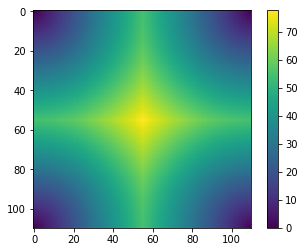

In [19]:
plt.imshow(k)
plt.colorbar()

In [20]:
corresponding_l = np.round(2*np.pi*k/x)
corresponding_c_l = np.zeros(corresponding_l.shape)
mask = corresponding_l < nl
corresponding_c_l[mask] = c_l[corresponding_l[mask].astype(int)] #this is the c_k matrix!
c_k = corresponding_c_l

Now plot the power spectrum of k:

In [21]:
sort = np.argsort(k.flatten())
k_for_plot = k.flatten()[sort]
c_k_for_plot = c_k.flatten()[sort]

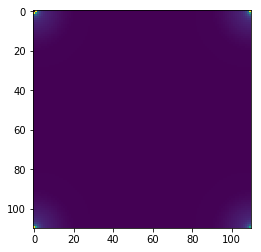

In [23]:
plt.imshow(c_k)

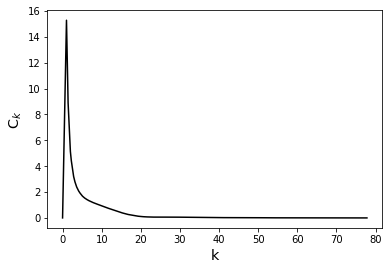

In [22]:
plt.plot(k_for_plot,c_k_for_plot,c='k')
plt.xlabel('k',fontsize='x-large')
plt.ylabel('C$_k$',fontsize='x-large')
plt.show()

Looks just like the one for $\ell$, which is good! Now I want to turn this into a map of the CMB on a flat sky region.


In [24]:
randmap = np.random.randn(c_k.shape[0],c_k.shape[1])
randmap_ft = np.fft.fft2(randmap)
cmb_map = np.real(np.fft.ifft2(randmap*np.sqrt(c_k),s=(npix,npix)))

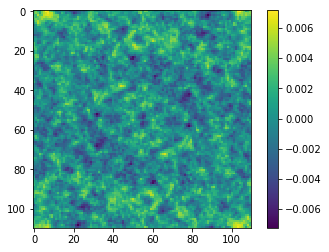

In [41]:
plt.imshow(np.real(cmb_map)) #Factors of 4pi, npix, l_max/k_max... To get variance same as full sky
plt.colorbar()
plt.show()

Compute the variance:

In [42]:
flat_map_var = np.var(np.real(cmb_map))

### Problem 3

Investigating the performance of a perfect 150 GHz detector in space

#### a)

Planck function is in [erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$ Sr$^{-1}$]. Typical detector will see 1 Sr of sky with a collecting area of $\lambda^{2}$. How many erg s$^{-1}$ Hz$^{-1}$ will hit the detector from the 2.725K CMB?

Planck function is:

$$B_\nu = \frac{2h\nu^3}{c^2}\frac{1}{e^{h\nu/kT} - 1}$$

Our detector will have a collecting area of $\lambda^2 = \left(\frac{c}{\nu}\right)^2$. So: to get the specific power hitting the detector:

$$P = \frac{2h\nu^3}{c^2}\frac{1}{e^{h\nu/kT} - 1} \times \left(\frac{c}{\nu}\right)^2 \times 1\  \text{Sr} = \frac{2h\nu}{e^{h\nu/kT} -1}\ \text{erg s$^{-1}$ Hz$^{-1}$} $$

Now, the detector detects at a frequency of 150 GHz and is looking at the 2.725 K CMB:

In [26]:
h = constants.h.cgs.value
k = constants.k_B.cgs.value
c = constants.c.cgs.value
T = 2.725

In [27]:
def blackbody(nu,T):
    num = 2*h*nu**3
    den = (c**2)*((np.exp(h*nu/(k*T))) - 1)
    return num/den

def power(nu,T):
    num = 2*h*nu
    den = np.exp(h*nu/(k*T)) - 1
    return num/den

In [28]:
print('The specific power hitting the detector will be %.2e erg/s/Hz.' % (power(150e9,T)))

The specific power hitting the detector will be 1.52e-16 erg/s/Hz.


#### b)
Now say we have a 30 GHz bandwidth (I will take this as 15 GHz above and below 150 GHz). What is the number of photons per second hitting the detector? First find the power, and then convert to photons per second by dividing out the photon energy.

In [29]:
nu = np.linspace(150e9-15e9,150e9+15e9,1000)
power = np.trapz(power(nu,T),nu)
print('The power is %.2e erg/s' % (power))

The power is 4.60e-06 erg/s


In [30]:
photon_E = h*(150e9)
print('The photons per second is %.2e photons/s' % (power/photon_E))

The photons per second is 4.62e+09 photons/s


Are we in the continuous or shock noise regime? Let's plot the blackbody spectrum to see qualitatively whether we are far below or above the peak:

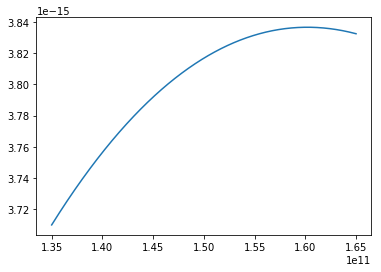

In [31]:
plt.plot(nu,blackbody(nu,T))

At 150 GHz, we are to the left of the BB peak (although only slightly) so we are in the continuous noise regime, although in reality it is probably more of a mix of shot and continuous noise. 

#### c)

Finding the noise in $\mu$K of the detector is simple using the radiometer equation:

$$\frac{\delta T}{T} = \frac{1}{\sqrt{Bt}}$$

In [32]:
del_T = (T/30e9**0.5/1.0)*1e6
print('The noise in uK is %.2f uK' % (del_T))

The noise in uK is 15.73 uK


This is very comparable to the noise in Planck 143 detectors, so not much better maps could be made with next generation CMB satellites.

# Appendix

### Questions answered at beginning of class

If $a_{lm}$ real: will get imaginary terms cancelling out in $T(\theta, \phi)$:

$$a_{lm} e^{im\phi} P_{lm} + a_{lm} e^{-im\phi} P_{lm}$$

We know $l = 0$ all have to be real. But in general complex: else will get sky being reflection which is non-physical. Can just make imaginary part of $a_{lm}$ from same distribution as real part